In [28]:
#importing requisite modules
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import copy

In [53]:
#reading in allFLYs data
with open('../Data/allFLYs.pkl', 'rb') as pickle_file:
    allFLYs = pickle.load(pickle_file, encoding = 'latin1')

In [29]:
#defining gaussian fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    g = offset + amplitude * np.exp(-(((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

In [30]:
#defining a function that gives the range of a dataset
#for creating boundaries
def span(data):
    return (max(data)-min(data))

In [31]:
def get_data(flight, freq_index):
    #getting data for specific flight
    flyData = []
    for i in range(len(allFLYs)):
        if allFLYs[i]['FLY']==flight:
            flyData = allFLYs[i]
            
    #checking if the flight data was obtained properly
    if len(flyData)==0:
        print('No flight with that number! Please enter one of the following for the flight argument: 340, 342, 343, 344, 347, 349, 351, 352, 353')
        return
    
    signal_array = np.empty((len(flyData['autos']), len(flyData['x'])), dtype = 'float')
    
    for i in range(len(flyData['autos'])):
        signal_array[i] = flyData['autos'][i][:,freq_index]
    
    thetaX_array = flyData['thetaX']
    thetaY_array = flyData['thetaY']
    
    return signal_array, thetaX_array, thetaY_array   

In [32]:
#getting boundaries for the gaussian fits
def get_boundaries(xdata, ydata):
    bounds = np.empty(4, dtype = object)
    for i in range(len(xdata)):
        lowerbounds = [-np.inf, min(xdata[i]), min(ydata[i]), -np.inf, -np.inf, -np.inf]
        upperbounds = [np.inf, max(xdata[i]), max(ydata[i]), span(xdata[i]), span(ydata[i]), np.inf]
        bounds[i] = (lowerbounds, upperbounds)
    
    return bounds

In [43]:
#getting initial guesses for the gaussian fits
def get_initial_guesses(signal, xdata, ydata):
    guesses = np.empty(4, dtype = object)
    
    for i in range(len(signal)):
        maxindex = np.where(signal[i] == max(signal[i]))
        guesses[i] = (max(signal[i]), xdata[i][maxindex], ydata[i][maxindex], 0.05, 0.05, 0)
        
    return guesses

In [45]:
#calculates a 2d gaussian for each dish
def calculate_gaussians(signal, xdata, ydata, guesses, bounds):
    gaussians = np.empty(4, dtype = object)
    covariance = np.empty(4, dtype = object)
    errors = np.empty(4, dtype = object)
    
    for i in range(len(signal)):
        gaussians[i], covariance[i] = opt.curve_fit(twoD_Gaussian, (xdata[i], ydata[i]), signal[i], p0 = guesses[i]
                                                    , maxfev = 100000, method = 'dogbox', bounds = bounds[i])
        errors[i] = np.sqrt(np.diag(covariance[i]))
    
    return gaussians, errors

In [49]:
# adds the x errors, y errors for all 4 dishes in quadrature
# to form an arbitrary measure of error to be minimized for the
# purposes of calculating time offset
def error_measure_calculator(errors):
    error_sum = 0
    for i in range(len(errors)):
        error_sum += (errors[i][1]**2 + errors[i][2]**2)
        
    error_measure = np.sqrt(error_sum)
    return error_measure

In [90]:
# time offset calculator
# realigns the signal and location data within some limits
# performs gaussian fits, and minimizes the x, y errors of all 4 dishes added in quadrature

def find_time_offset(flight, freq_index, offset_limit):
    
    #getting data to fit
    signal_array, thetaX_array, thetaY_array = get_data(flight, freq_index)
    
    #prepping output: offsets and errors
    offset_array = np.arange(-offset_limit, offset_limit)
    error_measure_array = np.zeros(len(offset_array))
    
    #trying all offsets
    for i in range(len(offset_array)):
        #preallocating temporary data objects
        tempSig = np.empty(4, dtype = object)
        tempX = np.empty(4, dtype = object)
        tempY = np.empty(4, dtype = object)
        
        #trimming signal and location data at opposite ends to simulate a time offset
        if offset_array[i] < 0:
            for j in range(len(tempSig)):
                tempSig[j] = signal_array[j][np.abs(offset_array[i]):]
                tempX[j] = thetaX_array[j][:(len(thetaX_array[j])-np.abs(offset_array[i]))]
                tempY[j] = thetaY_array[j][:(len(thetaY_array[j])-np.abs(offset_array[i]))]
        elif offset_array[i] > 0:
            for j in range(len(tempSig)):
                tempSig[j] = signal_array[j][:(len(signal_array[j])-np.abs(offset_array[i]))]
                tempX[j] = thetaX_array[j][np.abs(offset_array[i]):]
                tempY[j] = thetaY_array[j][np.abs(offset_array[i]):]
        else:
            tempSig = copy.deepcopy(signal_array)
            tempX = copy.deepcopy(thetaX_array)
            tempY = copy.deepcopy(thetaY_array)
        
        #calculating errors at this offset
        boundaries = get_boundaries(tempX, tempY)
        initial_guesses = get_initial_guesses(tempSig, tempX, tempY)
        
        gaussians, errors = calculate_gaussians(tempSig, tempX, tempY, initial_guesses, boundaries)
        
        error_measure_array[i] = error_measure_calculator(errors)
    
    return error_measure_array, offset_array

In [99]:
flightnames = []
time_conversions = []
# err_array = []     
# time_array = []
time_offsets = [[],[],[],[],[],[],[],[],[]]

for i in range(len(allFLYs)):
    flightnames.append(allFLYs[i]['FLY'])
    time_conversions.append((span(allFLYs[i]['mjdB'])*86400)/len(allFLYs[i]['x']))

for freq_index in range(0,256,16):
    for j in range(len(flightnames)):
        errors, offsets_index = find_time_offset(flightnames[j], freq_index, 40)
        offsets_time = offsets_index * time_conversions[j]
        time_offsets[j].append(offsets_time[np.where(errors==min(errors))])
#         err_array.append(errors)
#         time_array.append(offsets_time)

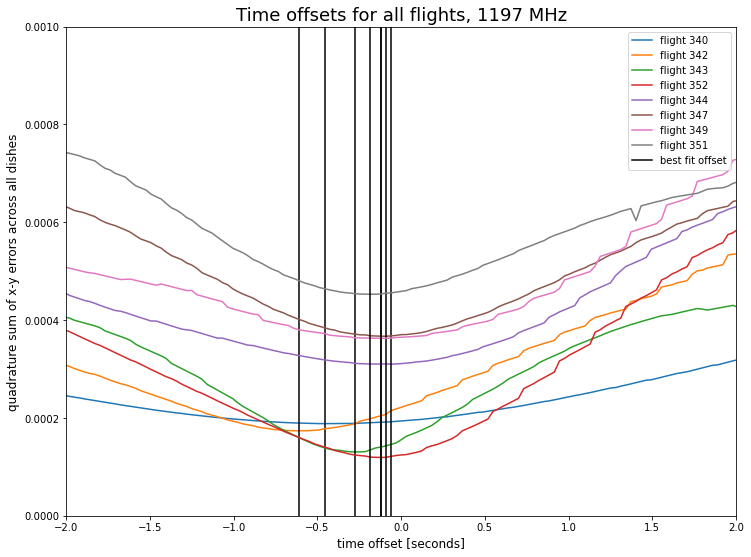

In [86]:
fig = plt.figure(figsize = (12,9))
plt.ylim(0,0.001)
plt.xlim(-2,2)
plt.xlabel('time offset [seconds]', fontsize = 12)
plt.ylabel('quadrature sum of x-y errors across all dishes', fontsize = 12)
for i in range(len(err_array)):
    if min(err_array[i]) < 0.001:
        plt.plot(time_array[i],err_array[i], label = 'flight '+flightnames[i])
    if time_array[i][np.where(err_array[i]==min(err_array[i]))] > -1:
        plt.plot([time_array[i][np.where(err_array[i]==min(err_array[i]))],time_array[i][np.where(err_array[i]==min(err_array[i]))]], [0,0.001], color = 'black')
plt.plot(10, 10, color = 'black', label = 'best fit offset')
plt.legend()
plt.title('Time offsets for all flights, 1197 MHz', fontsize = 18)

#plt.savefig('1197MHz_offsets.png')